## 本代码意在利用VGG19来进行迁移学习训练

In [1]:
# -*- coding=utf-8 -*-
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.optimizers import Adadelta
from keras.datasets import cifar10
from keras import applications

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

vgg_model=applications.VGG19(include_top=False,weights='imagenet')
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
(train_x,train_y),(test_x,test_y)=cifar10.load_data()
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## 训练目标转换为one-hot编码

In [6]:
n_classes=10
train_y=keras.utils.to_categorical(train_y,n_classes)
test_y=keras.utils.to_categorical(test_y,n_classes)

## bottleneck_feature

In [7]:
bottleneck_feature_train=vgg_model.predict(train_x,verbose=1)
bottleneck_feature_test=vgg_model.predict(test_x,verbose=1)

10000/10000 [==============================] - 142s 14ms/step


In [8]:
print(bottleneck_feature_train.shape,bottleneck_feature_test.shape)

(50000, 1, 1, 512) (10000, 1, 1, 512)


In [12]:
my_model=Sequential()
my_model.add(Flatten())###my_model.add(Flatten(input_shape=?))
my_model.add(Dense(512,activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(256,activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(n_classes,activation='softmax'))
my_model.compile(optimizer=Adadelta(),loss="categorical_crossentropy",\
                metrics=['accuracy'])
my_model.fit(bottleneck_feature_train,train_y,batch_size=128,epochs=50,verbose=1)

Epoch 1/50
50000/50000 [==============================] - 6s 127us/step - loss: 4.3122 - acc: 0.2744
Epoch 2/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.7972 - acc: 0.3813
Epoch 3/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6263 - acc: 0.4389
Epoch 4/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.5304 - acc: 0.4728
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.4762 - acc: 0.4984
Epoch 6/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.4208 - acc: 0.5146
Epoch 7/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.3842 - acc: 0.5328
Epoch 8/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.3577 - acc: 0.5427
Epoch 9/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.3217 - acc: 0.5531
Epoch 10/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.2988 - a

In [17]:
evaluation=my_model.evaluate(bottleneck_feature_test,test_y,batch_size=128,verbose=0)
print("loss:",evaluation[0],"accuracy:",evaluation[1])

loss: 1.3527788297653198 accuracy: 0.6257


In [35]:
def predict_label(img_idx,show_proba=True):
    plt.imshow(train_x[img_idx],aspect='auto')
    plt.title("Image to be labeled")
    plt.show()
    img_4D=(bottleneck_feature_train[img_idx])[np.newaxis,:,:,:]
    prediction=my_model.predict_classes(img_4D,batch_size=1,verbose=0)
    print("Actual class:{0}\nPredict class:{1}".format(np.argmax(train_y[img_idx],0),prediction))
    
    if show_proba:
        pred=my_model.predict_proba(img_4D,batch_size=1,verbose=0)
        print(pred)

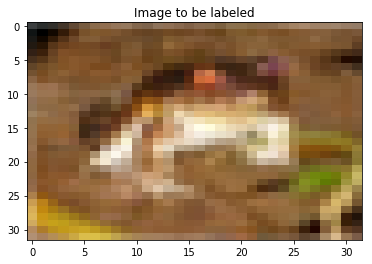

Actual class:6
Predict class:[6]
[[1.8340637e-05 1.1488760e-04 1.8745687e-02 4.8809566e-02 1.5615180e-02
  5.1468287e-02 8.6499536e-01 1.4321630e-04 6.2921521e-05 2.6633505e-05]]


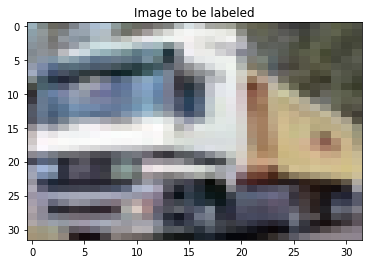

Actual class:9
Predict class:[9]
[[1.8463162e-08 2.3665652e-04 2.0290222e-13 5.5077754e-07 1.6875060e-11
  2.3355731e-09 9.8716616e-15 1.5281476e-07 7.2140537e-08 9.9976259e-01]]


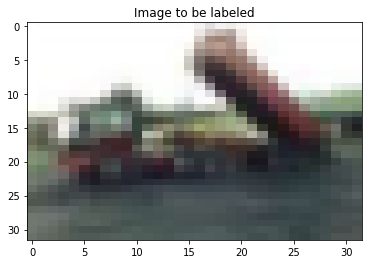

Actual class:9
Predict class:[9]
[[7.2271213e-02 5.3234766e-03 1.1195098e-05 5.4116783e-05 1.2791016e-04
  4.9549631e-06 4.8354312e-09 3.1195460e-03 6.9525046e-03 9.1213506e-01]]


In [36]:
for i in range(3):
    predict_label(i,show_proba=True)